In [1]:
import torch
import numpy as np

In [2]:
from networks.faceid.sphereface import sphere20a
from networks.denoise.pydl import ResDNet
from networks.denoise.pydl import UDNet
from networks.denoise.pydl import UDNetPA

In [3]:
#faceid = networks.sphereface.sphere20a()
faceid = sphere20a()

In [4]:
import os

gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [5]:
denoiser = ResDNet(kernel_size = (5, 5),
                input_channels = 3,
                output_features = 32,
                rpa_depth = 7,
                shortcut=(False,True))

In [6]:
denoiser = UDNetPA(kernel_size = (5, 5),
                input_channels = 3,
                output_features = 32,
                rpa_depth = 7,
                shortcut=(False,True))
denoiser_ckpt = torch.load("/home/safin/ckpt/1st_udnetpa/weigths_31")
denoiser.load_state_dict(denoiser_ckpt)
denoiser.cuda()

UDNetPA(depth = 7, convWeightSharing = True, shortcut = (False, True, True, True, True, True, True))

In [7]:
from datasets.noised import NoisedDataset

In [8]:
from torchvision import datasets, transforms

import random
class GaussianNoise(object):
    def __init__(self, std, mean=0, threshold = 0.5):
        self.std = std
        self.mean = mean
        self.threshold = threshold

    def __call__(self, img):
        if random.random() > self.threshold:
            return img
        
        if isinstance(self.std, list):
            std = np.random.choice(self.std)
        else:
            std = self.std
        return torch.clamp(img + torch.randn(*img.shape)*std + self.mean, 0, 1)
#         return img + torch.randn(*img.shape)*std + self.mean
#         return img + np.random.randn(*img.shape)*std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         transforms.RandomCrop((112,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()
                     ])
noised_dataset = NoisedDataset(train_data_dir, transform=transform, noise_transform=GaussianNoise(std=high_noise_std_arr, threshold=0.7))

In [9]:
noised_dataset[0][1].shape

torch.Size([3, 112, 96])

In [9]:
import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

import torch.nn as nn
import torch.optim as optim

In [9]:
denoiser.forward.__code__

<code object forward at 0x7f76601f9300, file "/home/safin/ms-thesis/networks/denoise/pydl.py", line 127>

In [10]:
batch_size = 128
dataloader = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

In [11]:
denoise_criterion = nn.L1Loss().cuda()
lr = 0.0005
optimizer = optim.Adam(denoiser.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-04)

batch_size = 128
batch_x = noised_dataset[0][0].repeat(batch_size,1,1,1)
batch_y = noised_dataset[0][1].repeat(batch_size,1,1,1)
for sample in dataloader:
    batch_x, batch_y, _ = sample
    data_x = batch_x.cuda()
    data_y = batch_y.cuda()
    data_x = data_x*255
    sigma = pydlutil.wmad_estimator(data_x)
    sigma = sigma.cuda()
    
    prediction = denoiser(data_x, sigma)
    loss = denoise_criterion(data_y, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

Process Process-2:
Process Process-8:
Process Process-3:
Process Process-4:
Process Process-10:
Process Process-12:
Process Process-9:
Process Process-1:
Process Process-7:
Process Process-11:
Process Process-5:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in 

  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py

KeyboardInterrupt: 

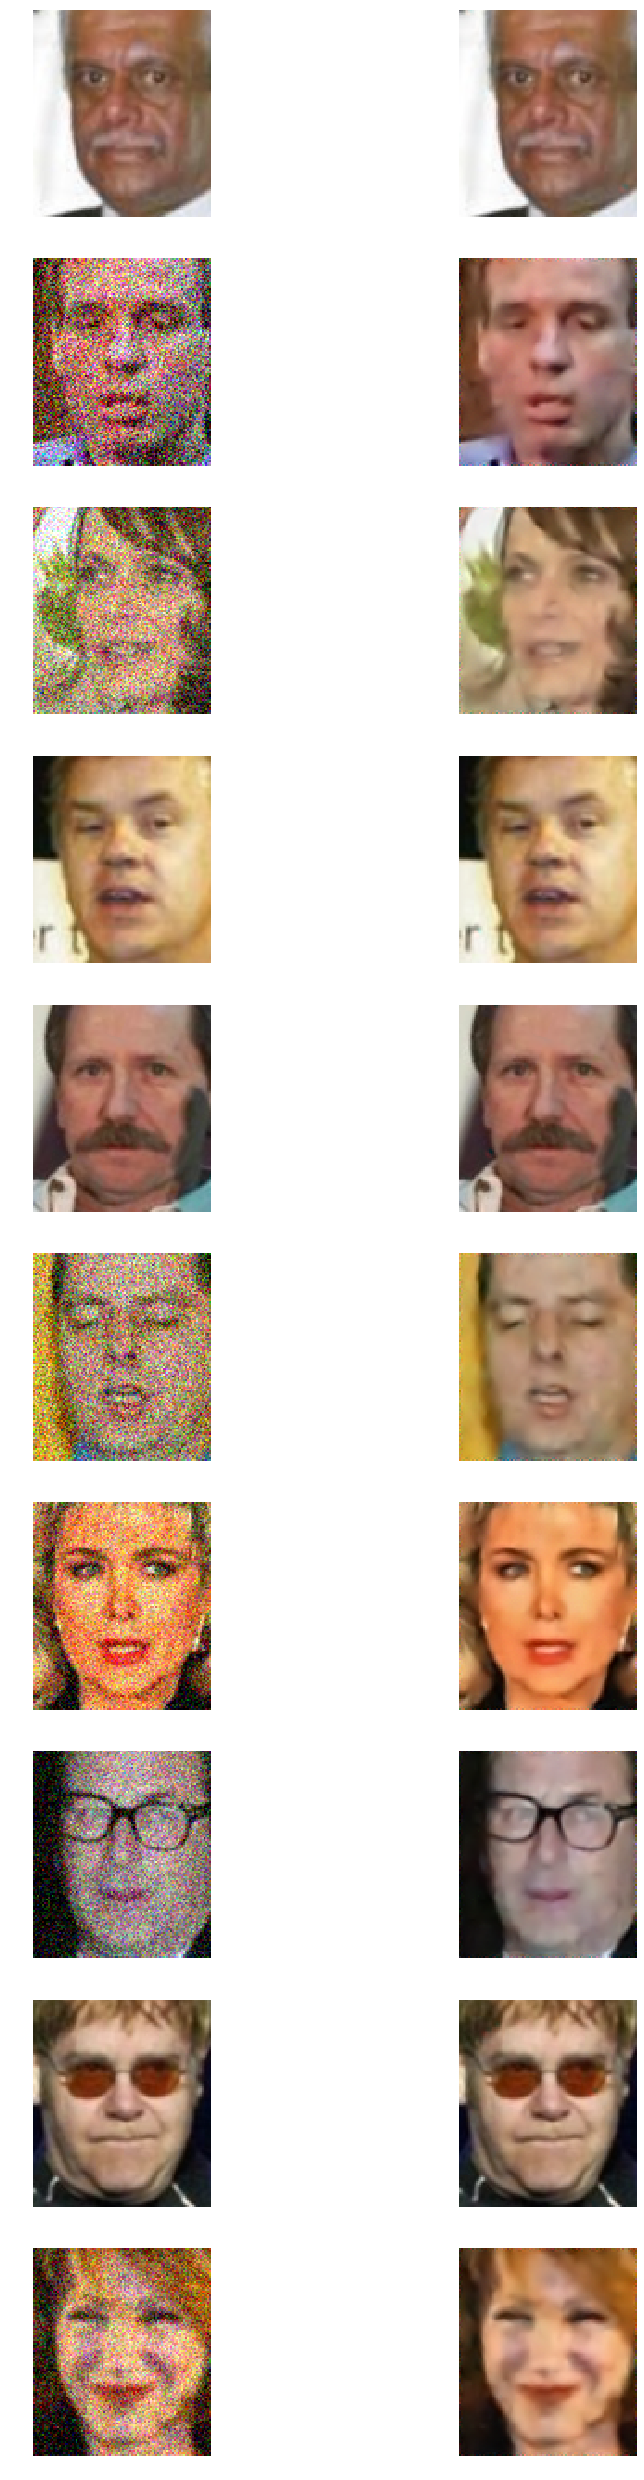

In [15]:
from datasets.lfw import LFWDataset
from transforms.noising import GaussianNoise

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

noise_transform = transforms.Compose([
                         transforms.ToTensor(),
                         GaussianNoise(high_noise_std_arr, clamp=[0,1])
                     ])

transform = noise_transform
lfw_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"
lfw_dataset = LFWDataset(lfw_data_dir, "/home/safin/datasets/lfw/pairsDevTrain.txt", transform, "png")
batch_size=10
dataloader_test = torch.utils.data.dataloader.DataLoader(lfw_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

for batch_idx, sample in enumerate(dataloader_test):
    data_x, data_y, _ = sample
    data_x, data_y = data_x.cuda(), data_y.cuda()
    data_x = data_x*255
    sigma = pydlutil.wmad_estimator(data_x)
    sigma = sigma.cuda()

    prediction = denoiser(data_x, sigma)
    break

noised = data_x.data.cpu().permute(0, 2, 3, 1).numpy()
prediction = prediction.data.cpu().permute(0, 2, 3, 1).numpy()

denoised = prediction.astype(np.uint8)
noised = noised.clip(0,255).astype(np.uint8)

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 2
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')

In [18]:
((prediction-127.5)/128).max()

0.99609375

In [13]:
batch_size = 10
dataloader_test = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

for batch_idx, sample in enumerate(dataloader_test):
    noised, groundtruth, _ = sample
    noised, groundtruth = noised.cuda(), groundtruth.cuda()
    sigma = pydlutil.wmad_estimator(noised)
    sigma = sigma.cuda()
    prediction = denoiser(noised, sigma)
    break

In [14]:
noised = noised.data.cpu().permute(0, 2, 3, 1).numpy()
prediction = prediction.data.cpu().permute(0, 2, 3, 1).numpy()
groundtruth = groundtruth.data.cpu().permute(0, 2, 3, 1).numpy()

denoised = prediction.astype(np.uint8)
noised = noised.clip(0,255).astype(np.uint8)
groundtruth = groundtruth.astype(np.uint8)

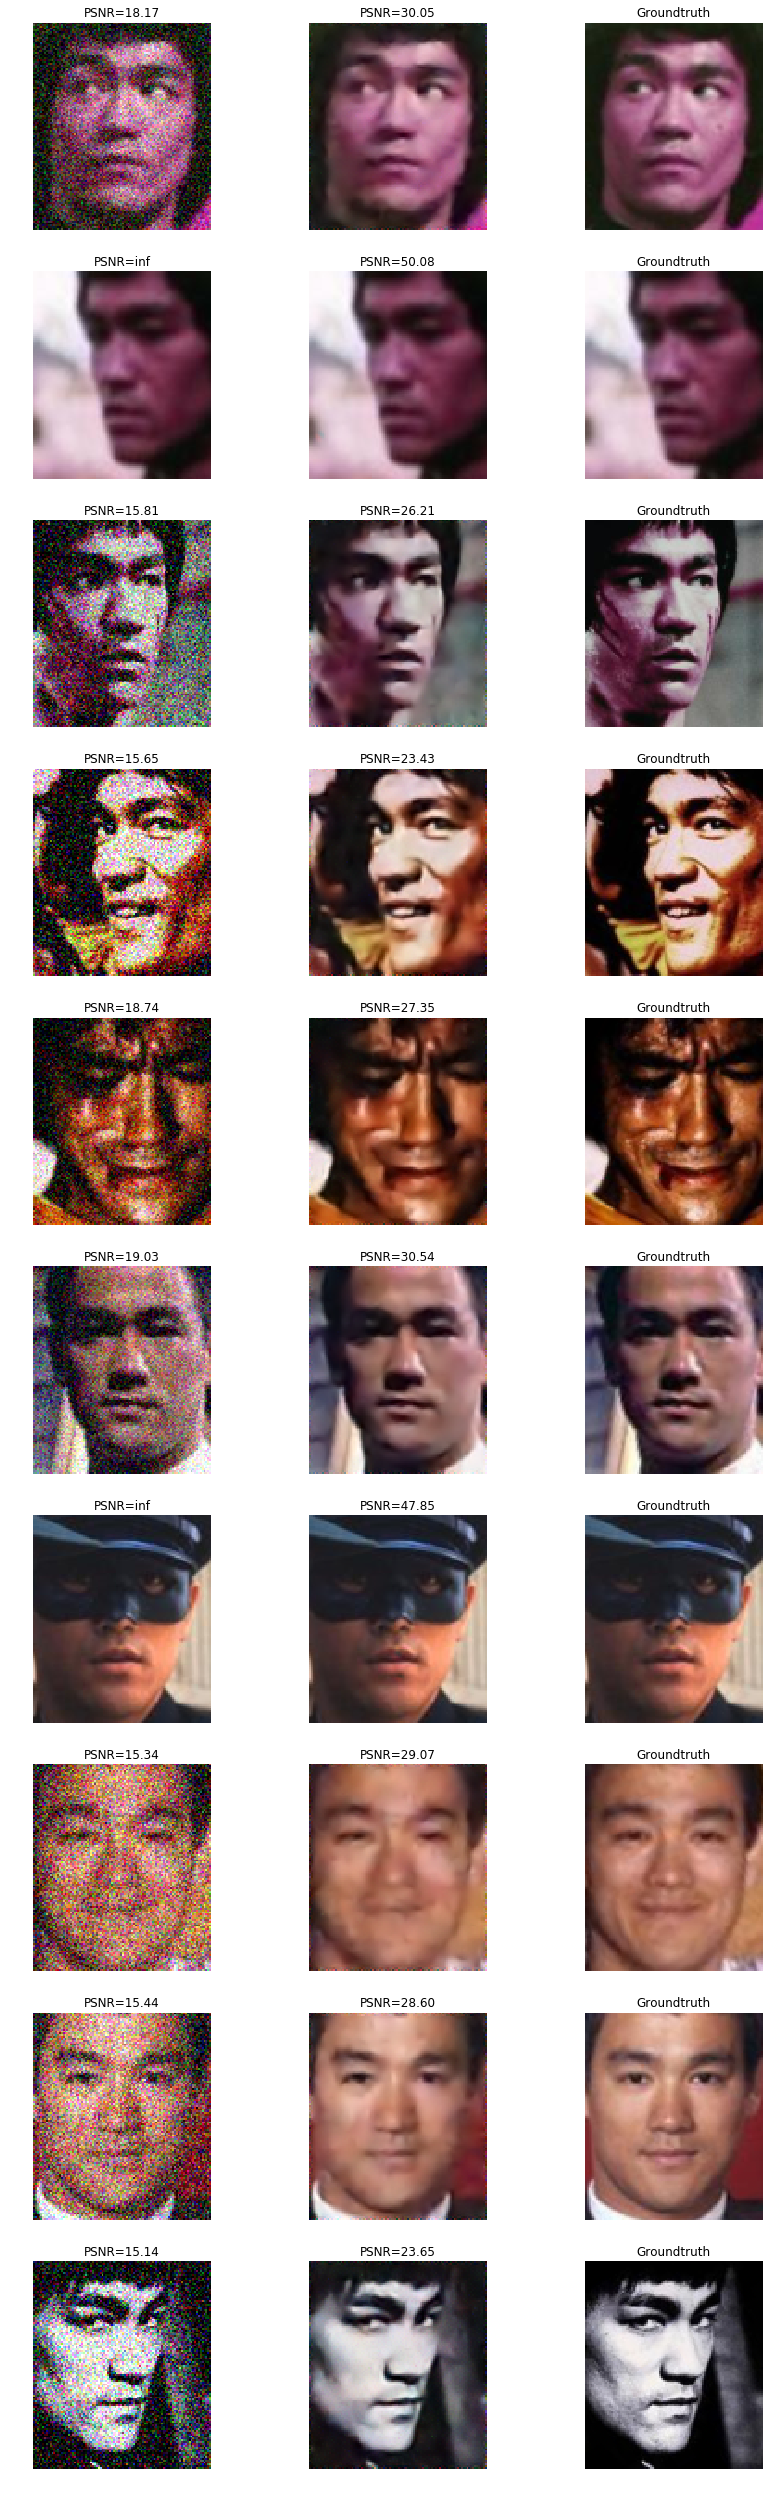

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 3
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    noised_psnr = psnr(noised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % noised_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')
    denoised_psnr = psnr(denoised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % denoised_psnr)
       
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(groundtruth[i])
    plt.axis('off')
    plt.title("Groundtruth")

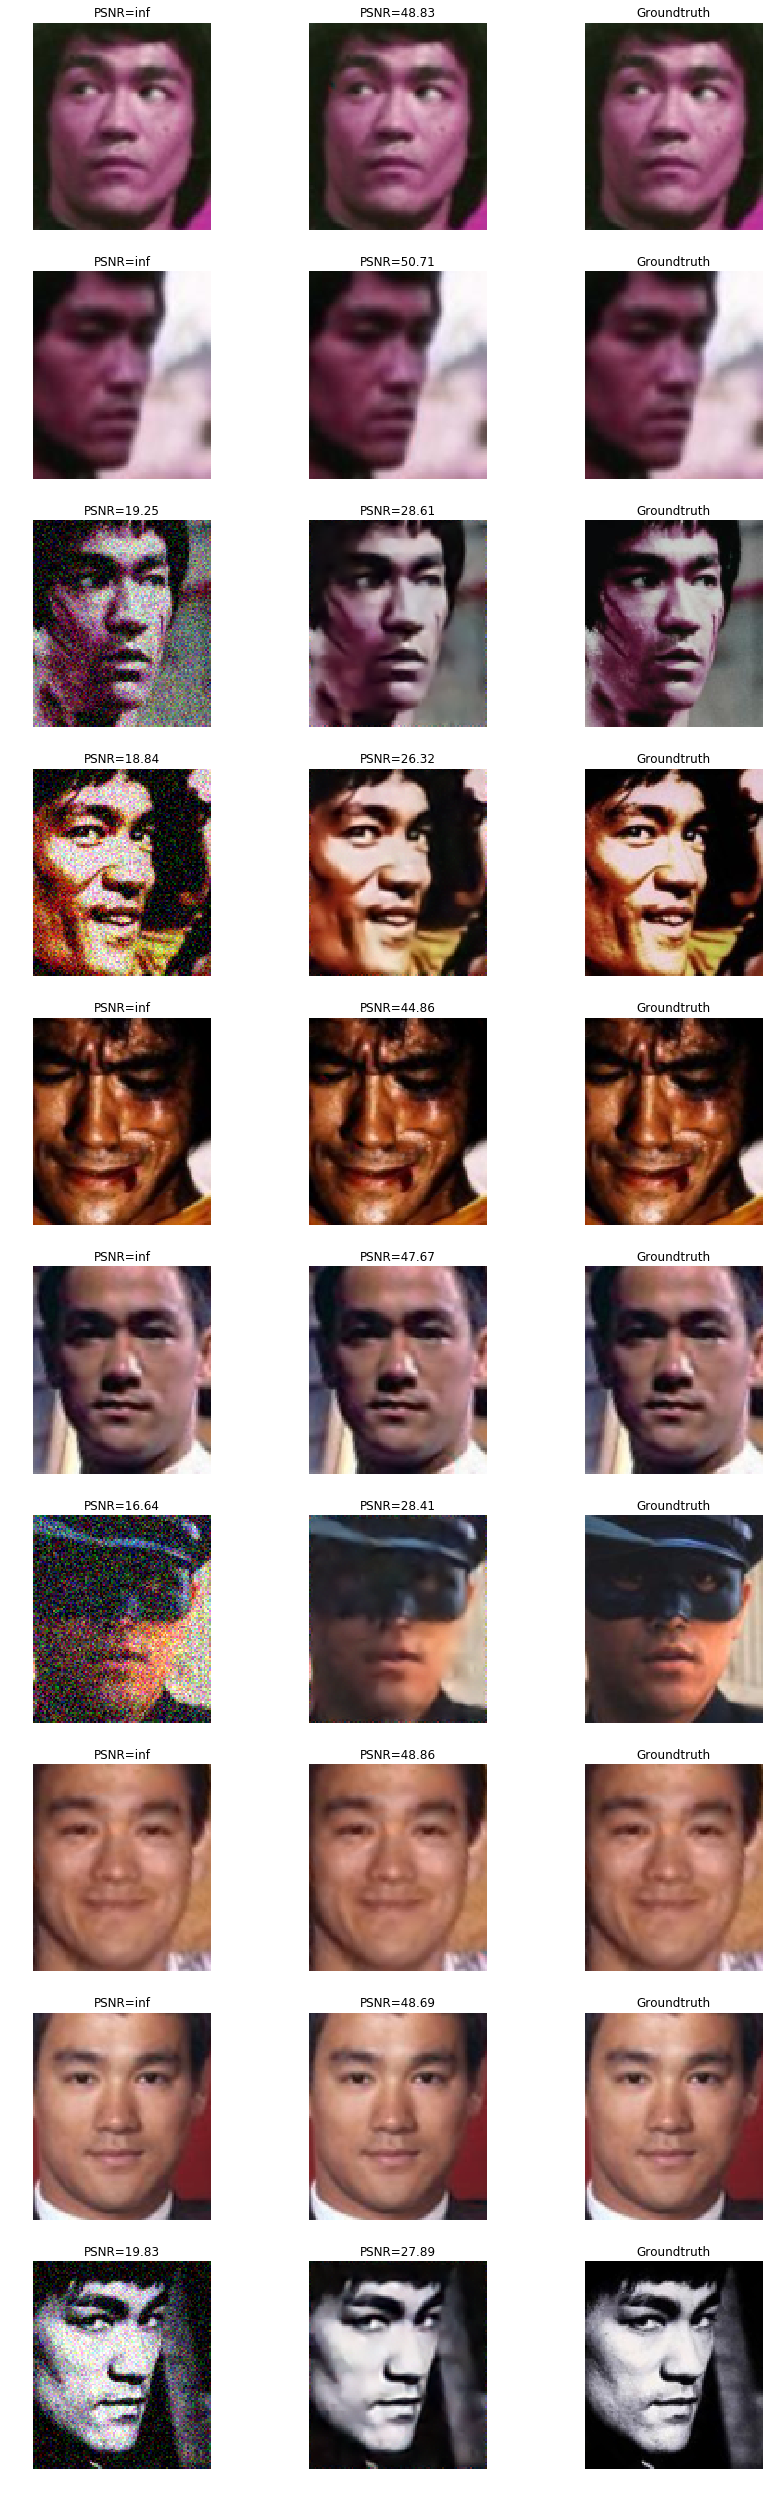

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 3
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    noised_psnr = psnr(noised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % noised_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')
    denoised_psnr = psnr(denoised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % denoised_psnr)
       
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(groundtruth[i])
    plt.axis('off')
    plt.title("Groundtruth")

In [7]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np

num_worker_threads = 10

q_denoised = queue.Queue()
q_noised = queue.Queue()
threads_denoised = []
threads_noised = []

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [8]:
from datasets.noised import NoisedDataset_w_dirs

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         transforms.RandomCrop((112,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()
                     ])
noised_dataset = NoisedDataset_w_dirs(train_data_dir, transform=transform, noise_transform=GaussianNoise(std=high_noise_std_arr, threshold=0.7))

batch_size = 64
dataloader_casia = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

for i in range(num_worker_threads):
    t = ImageSaver(q_denoised, "/home/safin/datasets/CASIA-WebFace/1st_udnet7pa_output/")
    t.start()
    threads_denoised.append(t)
    
for i in range(num_worker_threads):
    t = ImageSaver(q_noised, "/home/safin/datasets/CASIA-WebFace/1st_udnet7pa_input/")
    t.start()
    threads_noised.append(t)

In [9]:
import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

denoiser.eval()
denoiser.train(False)

import time

t_start = time.time()
for batch_idx, sample in tqdm.tqdm_notebook(enumerate(dataloader_casia)):
    noised, groundtruth, _, paths = sample
    noised, groundtruth = noised.cuda(), groundtruth.cuda()
    sigma = pydlutil.wmad_estimator(noised)
    sigma = sigma.cuda()
    denoised = denoiser(noised, sigma)

    for t in zip(denoised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_denoised.put_nowait(t)
        
    for t in zip(noised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_noised.put_nowait(t)

q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)
    
q_denoised.join()
for i in range(num_worker_threads):
    q_denoised.put(None)

for t in threads_noised:
    t.join()
    
for t in threads_denoised:
    t.join()


t_end = time.time()
print(t_end-t_start)


1670.7173216342926


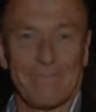

In [16]:
Image.open("/tmp/1st_udnet7pa_output/0000929/057.png")

In [17]:
denoised[0]

tensor([[[ 50.5539,   9.8163,  46.4437,  ...,  48.6909,  31.4932,  21.7835],
         [ 14.9313,  49.0610,  18.2568,  ...,  38.0528,  33.0241,  88.4904],
         [ 19.6012,  44.6934,  29.5162,  ...,  43.5135,  41.5585,  34.2520],
         ...,
         [179.2119, 203.4354, 195.0148,  ...,  46.1055,  41.7875,  55.4943],
         [182.4087, 205.7229, 196.2867,  ...,  57.4652,  64.0383,  22.4483],
         [234.8462, 148.2453, 254.8239,  ...,  47.8676,  46.5695, 119.9620]],

        [[ 98.2067,  45.8635,  30.0969,  ...,  20.4397,  31.7839,  52.8443],
         [ 46.6695,  47.2094,  38.8844,  ...,  40.1267,  36.7017,  26.2938],
         [ 41.0558,  53.1130,  48.2152,  ...,  48.6340,  41.2872,  32.2107],
         ...,
         [ 50.4121,  43.9883,  52.8804,  ...,  38.4984,  43.2581,  44.6068],
         [ 57.7725,  35.5150,  43.8840,  ...,  59.2010,  40.7702,  44.6427],
         [ 26.3669,  39.3603,  15.9106,  ...,  62.6460,  47.1137,  11.0624]],

        [[ 33.6806,   4.8220,  28.9872,  ...